<a href="https://colab.research.google.com/github/sgparrot/sgparrot2021Lv1-1/blob/main/MNIST/MNIST_%EB%B0%9C%ED%91%9C%EC%9E%90%EB%A3%8C_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification

In [ ]:
import os
import math
import argparse
import time
import random

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential
from tensorflow.data import Dataset
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau

from copy import deepcopy

### for notebook users
%matplotlib inline

## Preprocessing & Inspecting

### Defining Dataloader
tensorflow.keras.utils.Sequence를 상속받아서 Dataloader라는 class를 생성

In [ ]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x), np.array(batch_y)
    
    ### Epoch이 한 번 끝날 때마다 shuffle
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

### Generating Datasets

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


### Preprocessing

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32") / (2^8 - 1)
X_test = X_test.astype("float32") / (2^8 - 1)

y_train = to_categorical(y_train, 10)   # 변수화 필요
y_test = to_categorical(y_test, 10)     # 변수화 필요

In [ ]:
train_loader = Dataloader(X_train, y_train, 128, shuffle=True)   # 변수화 필요
test_loader = Dataloader(X_test, y_test, 128, shuffle=False)     # 변수화 필요

### Dataset Inspecting

In [ ]:
### 임시로 한 개의 minibatch를 돌려보는 상황

examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (128, 10)
Data  : (128, 28, 28, 1)


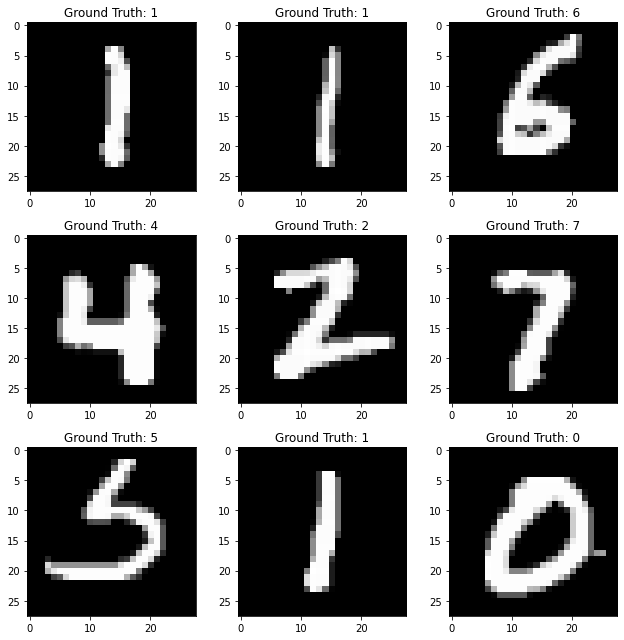

In [ ]:
fig = plt.figure(figsize=(9, 9))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="gray", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format(int(target)))

plt.show()

## Modeling
CNN Modeling도 OOP로 구현하고 싶었으나, 아직 이해도가 부족한 것 같습니다.

In [ ]:
def CNN(act, initial, dropout, use_bn):
    
    if act == "ReLU" or act == "relu":
        activation = "relu"
    elif act == "sigmoid":
        activation = "sigmoid"
    elif act == "tanh":
         activation = "tanh"
    elif act == "softmax":
        activation = "softmax"
    else:
        raise ValueError("Not a valid activation function.")
    
    if initial == "Xavier" or initial == "glorot":
        initializer = "glorot_uniform"
    elif initial == "he":
        initializer = "he_uniform"
    else:
        raise ValueError("Not a valid initializer.")
    
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation=activation,
                            kernel_initializer=initializer,
                            input_shape=(28, 28, 1)))
    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Conv2D(64, (3, 3), activation=activation))
    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Conv2D(64, (3, 3), activation=activation))
    if use_bn == True:
        model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation=activation))
    if use_bn == True:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout))
    
    model.add(layers.Dense(10, activation="softmax"))
    
    model.summary()
    
    return model

## Experiment

In [ ]:
def experiment(args):
    
    model = CNN(act=args.act, initial=args.initializer,
                dropout=args.dropout, use_bn=args.use_bn)
    
    if args.optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate=args.lr)
    elif args.optimizer == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=args.lr)
    elif args.optimizer == "Adam" or args.optimizer == "ADAM":
        optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)
    else:
        raise ValueError("Invalid Optimizer Choice.")
    
    model.compile(optimizer=optimizer, loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    hist = model.fit(X_train, y_train, batch_size=args.train_batch_size,
                 epochs=args.epoch, validation_split=0.2, verbose=1)
    
    return hist, model

## Hyperparametrization
변수를 조절하는 부분입니다. 변수를 바꾸어가며 실험해보고 싶은 부분은 list로 목록을 만든 후 <br>
for문을 이용하여 실행하면 되고, 적절한 값을 찾은 변수는 직접 입력하면 됩니다.

In [ ]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")

### Model
# args.model_code = "VGG16"    # 실행할 모델 이름 (미구현)
# args.in_channels = 1         # 뭐더라?
args.in_dim = 1 * 28 * 28      # 파일 크기
# args.hidden_dim = 100        # MLP의 Hidden Dimension (미구현)
args.out_dim = 10              # 0부터 9까지, 총 10가지
args.act = "ReLU"              # Activation Function(ReLU, sigmoid, tanh, softmax 구현) -> ReLU 확정
# args.n_layers = 1            # 뭐더라?
args.kernel_size = 3           # filter의 size

### Regulization
args.l2 = 1e-5                 # l2 정규화 alpha 값
args.use_bn = True             # Batch Normalization 사용 여부 -> True 확정
args.dropout = 0.2             # dropout 비율 -> 0.2 확정
args.initializer = "Xavier"    # Initializer 설정(Xavier, he 구현) -> Xavier 확정

### Training & Test
args.optimizer = "RMSprop"     # Optimizer 설정(SGD, RMSprop, Adam 구현) -> RMSprop 확정
args.lr = 0.001                # Learning Rate -> 0.001 확정
args.epoch = 5                 # Epoch 횟수 -> 5 확정
args.train_batch_size = 2**7   # Training Batch Size
args.test_batch_size = 2**7    # Test Batch Size



### Experiment Variable

name_var1 = []
name_var2 = []

list_var1 = [] 
list_var2 = []

## Evaluation

In [ ]:
model_list = []
hist_list = []

count = 0

for var1 in list_var1:
    for var2 in list_var2:
        
        setattr(args, name_var1, var1)   # args.name_var1 = var1과 같은 문법
        setattr(args, name_var2, var2)
        
        print(args)
        
        hist, model = experiment(deepcopy(args))
        
        model_list.append(model)
        hist_list.append(hist)

### Visualization for Train & Validation

In [ ]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("loss")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

In [ ]:
count = 0

for var1 in list_var1:
    for var2 in list_var2:
        
        print("-{0}: {1}, {2}: {3}"
              .format(name_var1, var1, name_var2, var2))
        
        print("Train Loss: {0}, \tTrain Accuracy: {1}"
              .format(hist_list[count].history["loss"][-1],
                     hist_list[count].history["accuracy"][-1]))
        print("Validation Loss: {0}, \tValidation Accuracy: {1}"
              .format(hist_list[count].history["val_loss"][-1],
                     hist_list[count].history["val_accuracy"][-1]))
        
        acc_loss_plot(hist_list[count])
        plt.show()
        
        count +=1

## Test

In [ ]:
count = 0

for var1 in list_var1:
    for var2 in list_var2:
        
        print("-{0}: {1}, {2}: {3}"
              .format(name_var1, var1, name_var2, var2))
        
        score = model_list[count].evaluate(X_test, y_test, verbose=0)
        print("Test Loss: {}".format(score[0]))
        print("Test Accuracy: {}\n".format(score[1]))
        
        count += 1

## FINAL RESULT

### Model 1

In [ ]:
### 다 실행해 본 후 마지막 결과 출력 시에는 이것을 사용

hist, model = experiment(deepcopy(args))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0

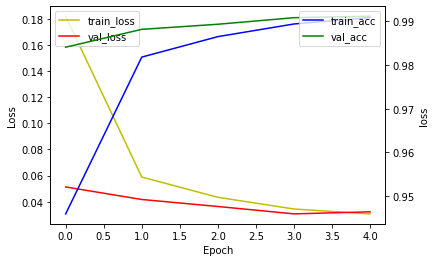

In [ ]:
acc_loss_plot(hist)

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss: {}".format(score[0]))
print("Test Accuracy: {}".format(score[1]))

Test Loss: 0.026036150753498077
Test Accuracy: 0.9918000102043152


### Model 2

In [ ]:
model = Sequential()
model.add(layers.Conv2D(32,(3,3), activation = 'relu', kernel_initializer ='he_uniform', input_shape = (28,28,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), padding = 'same', activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten()) 
model.add(layers.Dropout(0.5)) #overfitting 방지
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(10, activation="softmax"))
  
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)               

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, batch_size=100, epochs=15, validation_split=0.2, verbose=1)

Epoch 1/15
480/480 [==============================] - 2s 4ms/step - loss: 5.0523 - accuracy: 0.2260 - val_loss: 0.9371 - val_accuracy: 0.7125
Epoch 2/15
480/480 [==============================] - 2s 4ms/step - loss: 0.6423 - accuracy: 0.8172 - val_loss: 0.1378 - val_accuracy: 0.9628
Epoch 3/15
480/480 [==============================] - 2s 4ms/step - loss: 0.2130 - accuracy: 0.9417 - val_loss: 0.0894 - val_accuracy: 0.9755
Epoch 4/15
480/480 [==============================] - 2s 4ms/step - loss: 0.1551 - accuracy: 0.9577 - val_loss: 0.0802 - val_accuracy: 0.9780
Epoch 5/15
480/480 [==============================] - 2s 4ms/step - loss: 0.1239 - accuracy: 0.9654 - val_loss: 0.0628 - val_accuracy: 0.9830
Epoch 6/15
480/480 [==============================] - 2s 4ms/step - loss: 0.1015 - accuracy: 0.9710 - val_loss: 0.0602 - val_accuracy: 0.9844
Epoch 7/15
480/480 [==============================] - 2s 4ms/step - loss: 0.0895 - accuracy: 0.9738 - val_loss: 0.0497 - val_accuracy: 0.9868
Epoch 

baseline accuracy


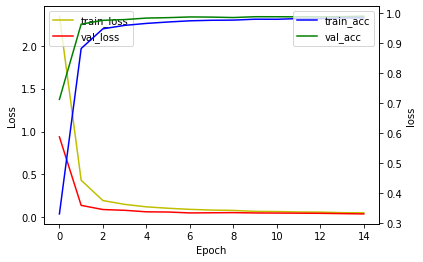

None


In [ ]:
print("baseline accuracy")
print(acc_loss_plot(hist))

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)
print("Test Loss: {}".format(score[0]))
print("Test Accuracy: {}".format(score[1]))

Test Loss: 0.034002818167209625
Test Accuracy: 0.9904000163078308


In [ ]:
### 예측 결과와 실제 값 비교

predicted_result = model.predict(X_test)
predicted_labels = np.argmax(predicted_result, axis = 1)
test_labels = np.argmax(y_test, axis=1)
print(predicted_labels[:10])
print(test_labels[:10])

[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]


In [ ]:
#틀린 데이터 개수

wrong_result = []

for n in range(0, len(y_test)):
    if predicted_labels[n] != test_labels[n]:
        wrong_result.append(n)

print(len(wrong_result))

96


In [ ]:
#틀린 것 중 랜덤하게 9개 확인

wrong = random.choices(population= wrong_result, k=9)
print(wrong)

[1247, 9634, 4294, 4956, 1260, 8408, 3005, 6505, 6597]


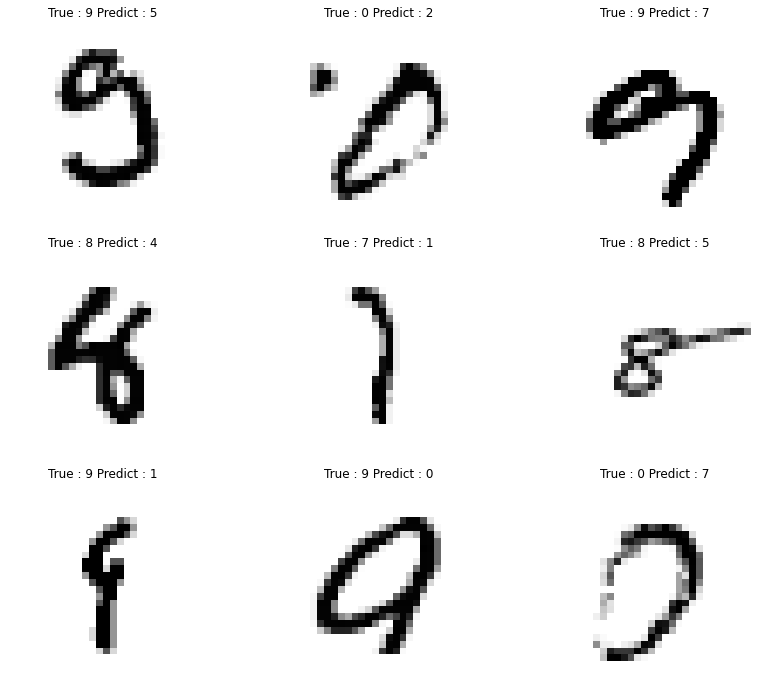

In [ ]:
#틀린 데이터 시각화 

plt.figure(figsize=(14, 12))

for idx, n in enumerate(wrong):
    plt.subplot(3, 3, idx + 1)
    plt.imshow(X_test[n].reshape(28, 28), cmap = 'Greys', interpolation='nearest')
    plt.title('True : ' + str(test_labels[n]) + ' Predict : ' + str(predicted_labels[n]))
    plt.axis('off')
    
plt.show()

### Model 3

In [ ]:
model=Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(28, 28, 1)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=64, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)       

In [ ]:
optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
learning_rate_reduction=ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [ ]:
history=model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_test, y_test),
                            verbose=1, callbacks=[learning_rate_reduction])

Epoch 1/50
469/469 [==============================] - 8s 13ms/step - loss: 0.2769 - accuracy: 0.9138 - val_loss: 0.0309 - val_accuracy: 0.9904
Epoch 2/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0467 - accuracy: 0.9864 - val_loss: 0.0265 - val_accuracy: 0.9913
Epoch 3/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0307 - accuracy: 0.9904 - val_loss: 0.0235 - val_accuracy: 0.9928
Epoch 4/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0287 - accuracy: 0.9912 - val_loss: 0.0203 - val_accuracy: 0.9933
Epoch 5/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0217 - accuracy: 0.9928 - val_loss: 0.0165 - val_accuracy: 0.9951
Epoch 6/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0171 - accuracy: 0.9943 - val_loss: 0.0214 - val_accuracy: 0.9933
Epoch 7/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0156 - accuracy: 0.9952 - val_loss: 0.0179 - val_accuracy: 0.9950

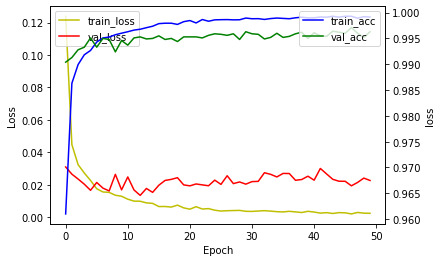

None


In [ ]:
print(acc_loss_plot(history))

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss: {}".format(score[0]))
print("Test Accuracy: {}".format(score[1]))

Test Loss: 0.022586103528738022
Test Accuracy: 0.9962999820709229


### Model 4
Model 3에서 오류, Epoch 수 등을 수정한 버전. <br>
이 Model에 맨 앞에서 소개한 Hyperparametrization을 이용하여 <br>
적절한 hyperparameter를 찾을 예정. (99.4% ~ 99.6% 예상)

In [ ]:
model=Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="Same", activation="relu", input_shape=(28, 28, 1)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="Same", activation="relu"))
model.add(layers.BatchNormalization())

model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu"))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Dense(10, activation="softmax"))
print(model.summary())

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction=ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.00001)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_17 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 64)       

In [ ]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=15,
                 validation_split=0.2, verbose=1,
                 callbacks=[learning_rate_reduction])

Epoch 1/15
375/375 [==============================] - 6s 14ms/step - loss: 0.3014 - accuracy: 0.9069 - val_loss: 0.0510 - val_accuracy: 0.9859
Epoch 2/15
375/375 [==============================] - 5s 13ms/step - loss: 0.0470 - accuracy: 0.9849 - val_loss: 0.0627 - val_accuracy: 0.9836
Epoch 3/15
375/375 [==============================] - 5s 13ms/step - loss: 0.0356 - accuracy: 0.9889 - val_loss: 0.0297 - val_accuracy: 0.9919
Epoch 4/15
375/375 [==============================] - 5s 13ms/step - loss: 0.0257 - accuracy: 0.9918 - val_loss: 0.0266 - val_accuracy: 0.9930
Epoch 5/15
375/375 [==============================] - 5s 13ms/step - loss: 0.0208 - accuracy: 0.9934 - val_loss: 0.0259 - val_accuracy: 0.9917
Epoch 6/15
375/375 [==============================] - 5s 13ms/step - loss: 0.0206 - accuracy: 0.9938 - val_loss: 0.0258 - val_accuracy: 0.9931
Epoch 7/15
375/375 [==============================] - 5s 13ms/step - loss: 0.0150 - accuracy: 0.9954 - val_loss: 0.0260 - val_accuracy: 0.9927

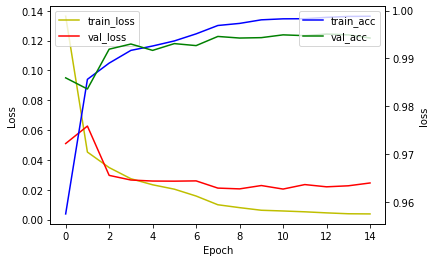

None


In [ ]:
print(acc_loss_plot(hist))

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss: {}".format(score[0]))
print("Test Accuracy: {}".format(score[1]))

Test Loss: 0.01736058108508587
Test Accuracy: 0.9952999949455261
